# 아마존 뷰티 제품 평점 정보:

 - 2M 개 이상의 고객 리뷰와 평점 정보를 포함한 데이터셋을 가지고 인기 제품 추천과 을 만들어 보자. 앞서 영화 추천과 비슷하게 진행가능하다.

 - 데이터셋에는 총 4가지 정보가 포함되어 있다:

   - 사용자 ID
   - 상품 ID (ASIN이라 부른다)
   - 평점 정보 (1-5)
   - 평점이 주어진 시간

* 앞서 2일차와 4일차 강의 내용을 기반으로 인기도 기반의 추천과 SVD 기반의 추천을 만들어 보자 

In [1]:
import pandas as pd
import numpy as np

amazon_ratings = pd.read_csv("https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/ratings_Beauty.csv")

4가지 정보 중에 하나라도 비어있는 레코드들을 모두 날리고 처음 5개의 레코드를 살펴본다

In [2]:
amazon_ratings = amazon_ratings.dropna()
amazon_ratings.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


몇개의 레코드와 몇개의 컬럼이 있는지 살펴본다

In [3]:
amazon_ratings.shape

(2023070, 4)

# 인기도 기반 추천 만들기

정보가 없는 사용자들에게 가장 쉽게 사용할 수 있는 형태의 추천 방식

리뷰의 수가 가장 큰 상품 10개를 계산해본다. 

In [4]:
popular_products = pd.DataFrame(amazon_ratings.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(10)

,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
B000ZMBSPE,2041
B003BQ6QXK,1918
B004OHQR1Q,1885
B00121UVU0,1838


이 10개를 바 그래프로 그려본다

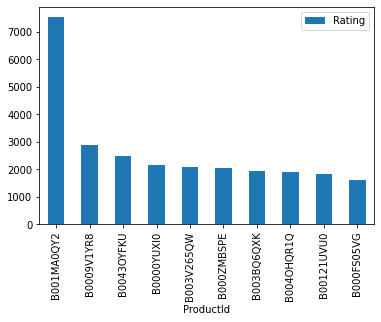

In [5]:
most_popular.head(10).plot(kind = "bar")

리뷰 수가 어느 정도 이상되는 상품을 대상으로 평균 평점이 4이상인 뷰티 상품을 리턴하게 해보자. 

In [29]:
most_popular_rating = pd.merge(most_popular, amazon_ratings, left_on='ProductId', right_on='ProductId')
most_popular_rating.head()
rating_summary = most_popular_rating[["ProductId", "Rating_y"]].groupby(["ProductId"]).agg(["count", "median", "mean"])
rating_summary.columns = ["count", "median", "mean"]
rating_summary[rating_summary["mean"] >=4 ].sort_values("count", ascending=False).head(10)

,count,median,mean
ProductId,,,
B001MA0QY2,7533,5.0,4.321386
B0043OYFKU,2477,5.0,4.310456
B0000YUXI0,2143,5.0,4.405040
B003V265QW,2088,5.0,4.365421
B000ZMBSPE,2041,5.0,4.422342
B003BQ6QXK,1918,5.0,4.625652
B004OHQR1Q,1885,5.0,4.465782
B00121UVU0,1838,5.0,4.538085
B000FS05VG,1589,5.0,4.159849


# 모델 기반 CF 추천 시스템 만들기

평점 행렬을 기반으로 SVD++를 사용해보는 방식. 앞서 사용해본 surprise 모듈을 사용하던지 scikit-learn의 TruncatedSVD를 사용해본다

In [30]:
amazon_ratings1 = amazon_ratings.head(10000)

In [31]:
ratings_utility_matrix = amazon_ratings1.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_utility_matrix.head()

ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,...,B000052YPE,B000052YPF,B000052YPG,B000052YPH,B000052YPM,B000052YPU,B000052YPV,B000052YPY,B000052YQ0,B000052YQ2
UserId,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A024581134CV80ZBLIZTZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03056581JJIOL5FSKJY7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03099101ZRK4K607JVHH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0505229A7NSH3FRXRR4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
ratings_utility_matrix.shape

(9697, 886)

In [33]:
X = ratings_utility_matrix.T
X.head()

UserId,A00205921JHJK5X9LNP42,A024581134CV80ZBLIZTZ,A03056581JJIOL5FSKJY7,A03099101ZRK4K607JVHH,A0505229A7NSH3FRXRR4,A05492663T95KW63BR75K,A059547920Q3LZVFHLPI3,A07410232KYRFR25CIUGJ,A082796624UNM47DSAI6K,A0864963DOAY7LXGS5I6,...,AZW1HXXYAC15B,AZWRTJPN7NXT,AZWTXHXZXFAYP,AZYQEFB9Y5N22,AZZHB6U54UDYW,AZZHJZP4GQPPZ,AZZNK89PXD006,AZZOFVMQC0BJG,AZZQXL8VDCFTV,AZZTJQ7CQZUD8
ProductId,,,,,,,,,,,,,,,,,,,,,
0205616461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0558925278,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0733001998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0737104473,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0762451459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
X.shape

(886, 9697)

In [35]:
X1 = X

In [36]:
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(886, 10)

In [39]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(886, 886)

뒷 부분은 각자 Surprise 구현을 바탕으로 만들어보기 바란다

In [40]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 5.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1634012 sha256=2bad289004e768d3b57a5e5e6be62fae359ef3d10f9182c1e370e169491e7451
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [41]:
from surprise import Dataset
from surprise import Reader
from collections import defaultdict

# reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
# data = Dataset.load_from_file("ratings.csv", reader=reader)

In [ ]:
from surprise import SVD
from surprise import NormalPredictor
from surprise.model_selection import GridSearchCV